In [2]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
from scipy.stats import gaussian_kde

## Calculates a probability distribution of observed intersection angles from 2016-2025

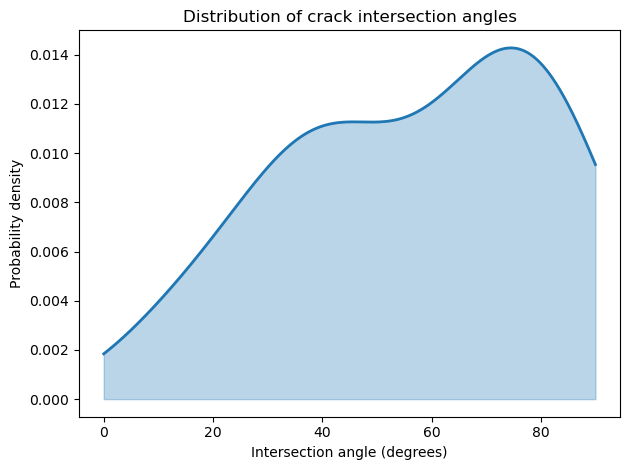

In [3]:

def unpack_jsons(processed_path):
    
    with open(processed_path) as fin:
        chains = json.load(fin)

    filename = os.path.basename(processed_path)
    return chains

def local_tangent(line, point, eps=1e-6):
    """
    Approximate unit tangent vector of a LineString at a Point.
    """
    s = line.project(point)

    s0 = max(s - eps, 0.0)
    s1 = min(s + eps, line.length)

    p0 = np.array(line.interpolate(s0).coords[0])
    p1 = np.array(line.interpolate(s1).coords[0])

    v = p1 - p0
    return v / np.linalg.norm(v)


def angle_between(v1, v2):
    cosang = np.dot(v1, v2)
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))


def find_intersecting_cracks(chains):
    """
    Topological crack intersection detection using Shapely.
    Returns one angle per physical junction.
    """

    # Build LineStrings
    lines = {}
    for name, chain in chains.items():
        coords = list(zip(chain["lon"], chain["lat"]))
        lines[name] = LineString(coords)

    intersections = []

    names = list(lines.keys())
    for i in range(len(names)):
        for j in range(i + 1, len(names)):

            name_i = names[i]
            name_j = names[j]

            li = lines[name_i]
            lj = lines[name_j]

            geom = li.intersection(lj)

            if geom.is_empty:
                continue

            # Handle single intersection point
            if isinstance(geom, Point):
                pts = [geom]

            # Handle MultiPoint
            else:
                try:
                    pts = list(geom.geoms)
                except AttributeError:
                    continue  # overlaps (LineString) — ignore for angle stats

            for pt in pts:
                ti = local_tangent(li, pt)
                tj = local_tangent(lj, pt)

                angle = angle_between(ti, tj)
                angle = min(angle, 180.0 - angle)  # acute angle

                intersections.append({
                    "chain_i": name_i,
                    "chain_j": name_j,
                    "lat": pt.y,
                    "lon": pt.x,
                    "angle_deg": angle
                })

    return intersections

# Batch calculation
angles = []
input_dir = Path("Sentinel2_cracks_processed")
for json_path in sorted(input_dir.glob("*.json*")):
    chains = unpack_jsons(json_path)
    intersections = find_intersecting_cracks(chains)
    angles = np.array(
    [a for d in intersections for a in np.atleast_1d(d["angle_deg"])],
    dtype=float
)

angles = np.asarray(angles, dtype=float)

if len(angles) == 0:
    print("No intersecting cracks found — nothing to plot.")
else:
    kde = gaussian_kde(angles)

    x = np.linspace(0.0, 90.0, 500)
    pdf = kde(x)

    plt.figure()
    plt.plot(x, pdf, lw=2)
    plt.fill_between(x, pdf, color="tab:blue", alpha=0.3)
    plt.xlabel("Intersection angle (degrees)")
    plt.ylabel("Probability density")
    plt.title("Distribution of crack intersection angles")
    plt.tight_layout()
    plt.show()



(38, 2)
(1, 2)
i=0, bin_center_deg=2.500
  theta_deg_for_pdf = 2.5
  theta_rad = 0.04363323129985824
  mass = [0.01151157]
  arc = [0.01151157]
  slope = 0.9990482215818578
  tangent_angle (rad) = 2.356670605943805
  delta_r = [[-0.00814378  0.00813603]]
  new_r = [[-0.00814378  0.00813603]]
---
(1, 2)
i=1, bin_center_deg=7.500
  theta_deg_for_pdf = 7.499999999999999
  theta_rad = 0.1308996938995747
  mass = [0.01681866]
  arc = [0.01681866]
  slope = 0.9914448613738104
  tangent_angle (rad) = 2.3604904092830137
  delta_r = [[-0.01194357  0.01184139]]
  new_r = [[-0.02008735  0.01997742]]
---
(1, 2)
i=2, bin_center_deg=12.500
  theta_deg_for_pdf = 12.5
  theta_rad = 0.2181661564992912
  mass = [0.02287041]
  arc = [0.02287041]
  slope = 0.9762960071199333
  tangent_angle (rad) = 2.3681880661597057
  delta_r = [[-0.01636461  0.01597671]]
  new_r = [[-0.03645196  0.03595413]]
---
(1, 2)
i=3, bin_center_deg=17.500
  theta_deg_for_pdf = 17.5
  theta_rad = 0.30543261909900765
  mass = [0.02

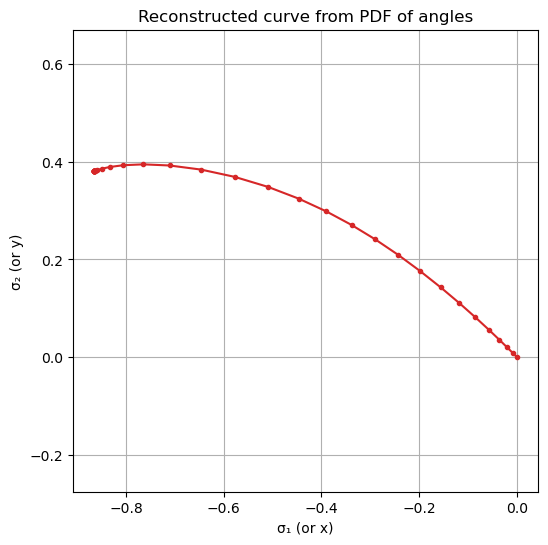

In [4]:
from scipy.io import savemat
# Initialize position array
bins = np.linspace(0, 180, 37)
bin_centers = (bins[:-1] + bins[1:]) / 2.0
bin_width_deg = bins[1] - bins[0]
r_array = np.zeros((len(bins) + 1, 2))
print(r_array.shape)

# Iterate through bins and accumulate positions
for i, b in enumerate(bins):
    theta_i = np.radians(b + 2.5)  # convert to radians!
    
    # 2. Compute PDF mass at that angle and convert to arc length
    mass = kde(np.degrees(theta_i)) * bin_width_deg
    arc = 1 * mass  # can scale total curve length later

    # 3. Compute slope and tangent direction
    slope = - np.cos(np.pi - theta_i) # from coulombic shear criterion
    tangent_angle = np.arctan2(slope,-1)

    # 4. Increment position
    delta_r = np.array([arc * np.cos(tangent_angle), arc * np.sin(tangent_angle)]).T
    print(delta_r.shape)

    r_array[i+1, :] = r_array[i,:] + delta_r  # cumulative update

    ## DEBUG
    if i < 10:
        print(f"i={i}, bin_center_deg={b + bin_width_deg/2:.3f}")
        print("  theta_deg_for_pdf =", np.degrees(theta_i) if theta_i is not None else '??')
        print("  theta_rad =", theta_i)
        print("  mass =", mass)
        print("  arc =", arc)
        print("  slope =", slope)
        print("  tangent_angle (rad) =", tangent_angle)
        print("  delta_r =", delta_r)
        print("  new_r =", r_array[i] + delta_r)
        print("---")
print(r_array.shape)
        
plt.figure(figsize=(6, 6))
plt.plot(r_array[:,0], r_array[:,1], '-o', color='tab:red', lw=1.5, markersize=3)
plt.title("Reconstructed curve from PDF of angles")
plt.xlabel("σ₁ (or x)")
plt.ylabel("σ₂ (or y)")
plt.axis('equal')
plt.grid(True)
plt.show()

# Save as polygon that can be opened in MATLAB
r_mirror = r_array.copy()
r_mirror[:,1] = -r_mirror[:,1]

polygon = np.vstack([
    r_array,
    r_mirror[::-1]
])
polygon = np.vstack([polygon, polygon[0]])

savemat("yield_polygon.mat", {"yield_polygon": polygon})

In [5]:
def reconstruct_curve(angle_samples, bins, bin_width_deg):
    kde = gaussian_kde(angle_samples)

    r_array = np.zeros((len(bins) + 1, 2))

    for i, b in enumerate(bins):
        theta_i = np.radians(b + bin_width_deg/2)

        mass = kde(np.degrees(theta_i)) * bin_width_deg
        arc = mass

        slope = -np.cos(np.pi - theta_i)
        tangent_angle = np.arctan2(slope, -1)

        delta_r = arc * np.array([
            np.cos(tangent_angle),
            np.sin(tangent_angle)
        ])

        r_array[i+1] = r_array[i] + delta_r

    return r_array


## Generate exgaussian pdfs from (Ringeisen et al. 2023)

In [6]:
def exgaussian_angle_pdf(n, mu, sigma, tau, random_state=None):
    """
    Generate samples from a wrapped exGaussian distribution (angles in degrees)
    and plot the histogram + fitted PDF.

    Parameters
    ----------
    n : int
        Number of random samples to generate.
    mu : float
        Mean of the Gaussian part (degrees).
    sigma : float
        Standard deviation of the Gaussian part (degrees).
    tau : float
        Mean of the exponential component (degrees).
    plot : bool
        Whether to show a circular histogram with the PDF.
    random_state : int or None
        Optional seed for reproducibility.

    Returns
    -------
    samples_deg : ndarray
        Array of wrapped angles in degrees, shape (n,).
    pdf_func : callable
        Function `pdf(angle_deg)` that returns the wrapped exGaussian PDF.
    """

    rng = np.random.default_rng(random_state)

    # Generate Samples
    normal_part = rng.normal(loc=mu, scale=sigma, size=n)
    exp_part = rng.exponential(scale=tau, size=n)
    samples_linear = normal_part + exp_part
    samples_deg = np.mod(samples_linear, 180.0)  # wrap to [0, 180)
    return samples_deg

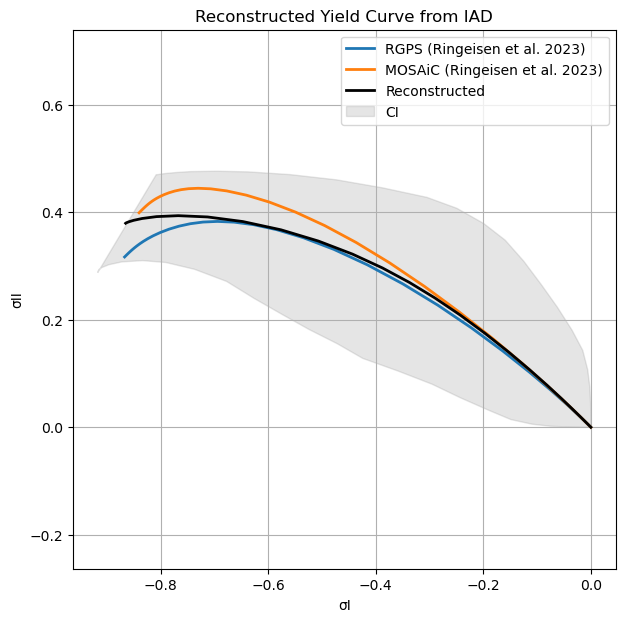

In [7]:
from scipy.stats import gaussian_kde

n_boot = 500
N = len(angles)

r_boot = np.zeros((n_boot, len(bins)+1, 2))

for k in range(n_boot):
    resampled = np.random.choice(angles, size=N, replace=True)
    r_boot[k] = reconstruct_curve(resampled, bins, bin_width_deg)

lower = np.percentile(r_boot, 2.5, axis=0) 
upper = np.percentile(r_boot, 97.5, axis=0)

r_mean = r_boot.mean(axis=0)

# From Ringeisen et al.
rgps_samples = exgaussian_angle_pdf(7578, 34.05, 13.58, 32.54)
mosaic_samples = exgaussian_angle_pdf(608, 27.18, 12.94, 32.52)

rgps_array = reconstruct_curve(rgps_samples, bins, bin_width_deg)
mosaic_array = reconstruct_curve(mosaic_samples, bins, bin_width_deg)

#PLOTTING
plt.figure(figsize=(7,7))

plt.plot(rgps_array[:,0], rgps_array[:,1], lw=2, label='RGPS (Ringeisen et al. 2023)')
plt.plot(mosaic_array[:,0], mosaic_array[:,1], lw=2, label='MOSAiC (Ringeisen et al. 2023)')

plt.plot(r_mean[:,0], r_mean[:,1], lw=2, color='black', label='Reconstructed')
plt.fill(
    np.concatenate([lower[:,0], upper[::-1,0]]),
    np.concatenate([lower[:,1], upper[::-1,1]]),
    alpha=0.2,
    color='gray',
    label = 'CI'
)

plt.title("Reconstructed Yield Curve from IAD")
plt.xlabel("σI")
plt.ylabel("σII")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

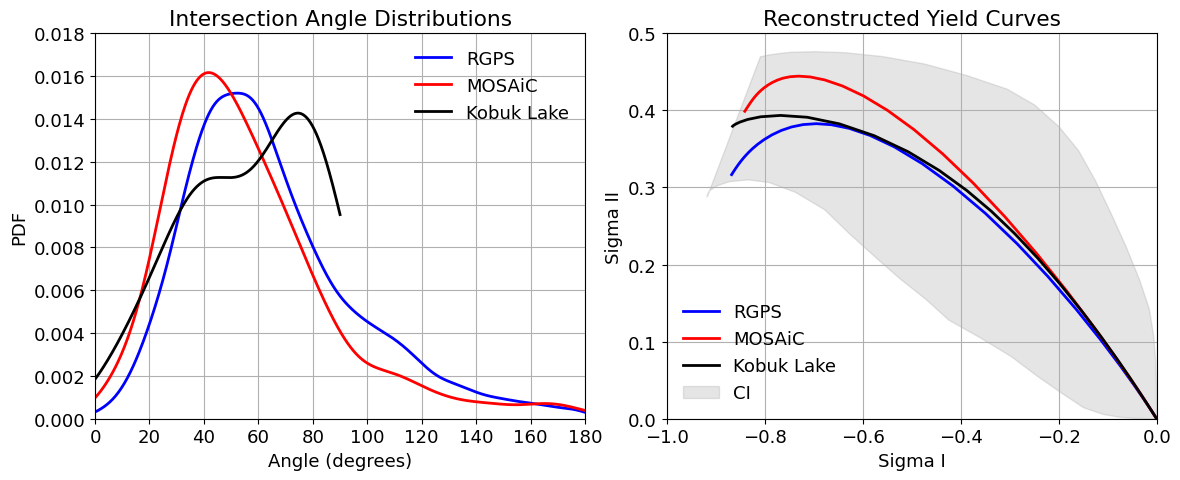

In [24]:
plt.rcParams.update({'font.size': 13})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

kde = gaussian_kde(angles)
rgps_kde = gaussian_kde(rgps_samples)
mosaic_kde = gaussian_kde(mosaic_samples)

x = np.linspace(0.0, 90.0, 500)
x_180 = np.linspace(0.0, 180.0, 500)
pdf_angles = kde(x)
pdf_rgps = rgps_kde(x_180)
pdf_mosaic = mosaic_kde(x_180)

# Panel 1
axes[0].plot(x_180, pdf_rgps, 'b', lw=2, label='RGPS')
axes[0].plot(x_180, pdf_mosaic, 'r', lw=2, label='MOSAiC')
axes[0].plot(x, pdf_angles, 'k', lw=2, label='Kobuk Lake')
axes[0].set_title('Intersection Angle Distributions')
axes[0].set_xlabel('Angle (degrees)')
axes[0].set_ylabel('PDF')
axes[0].set_xlim(0,180)
axes[0].set_ylim(0, 0.018)
axes[0].grid(True)
axes[0].legend(frameon=False)

# Panel 2
axes[1].plot(rgps_array[:,0], rgps_array[:,1], 'b', lw=2, label='RGPS')
axes[1].plot(mosaic_array[:,0], mosaic_array[:,1], 'r', lw=2, label='MOSAiC')
axes[1].plot(r_mean[:,0], r_mean[:,1], lw=2, color='black', label='Kobuk Lake')
axes[1].fill(
    np.concatenate([lower[:,0], upper[::-1,0]]),
    np.concatenate([lower[:,1], upper[::-1,1]]),
    alpha=0.2,
    color='gray',
    label = 'CI'
)

axes[1].set_title('Reconstructed Yield Curves')
axes[1].set_xlabel('Sigma I')
axes[1].set_ylabel('Sigma II')
axes[1].set_xlim(-1.0, 0.0)
axes[1].set_ylim(0.0, 0.5)
axes[1].grid(True)

axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()